# Recommendations with IBM

In this project I'll analyze the interactions that users have with articles on the IBM Watson Studio platform, and make recommendations to them about new articles that they might like. The data and project concept our provided by [Udacity's course on Data Science](https://www.udacity.com/course/data-scientist-nanodegree--nd025).

## Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

df = pd.read_csv('../data/user-item-interactions.csv')
df_content = pd.read_csv('../data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df['article_id'] = df['article_id'].astype('int') 
print(df.shape)
df.head()

(45993, 3)


,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [76]:
print(df_content.shape)
df_content.head()

(1051, 7)


,doc_body,doc_description,doc_full_name,doc_status,article_id,content,similarity
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0,Detect Malfunctioning IoT Sensors with Streami...,0.015207
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1,Communicating data science: A guide to present...,0.029807
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2,"This Week in Data Science (April 18, 2017) Her...",0.045109
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3,DataLayer Conference: Boost the performance of...,0.011352
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4,Analyze NY Restaurant data using Spark in DSX ...,0.029549


In [4]:
df_content['article_id'] = df_content['article_id'].astype('int') 

## Exploratory Data Analysis

### Duplicates 

In [5]:
df_content.duplicated('article_id').sum()

5

In [6]:
df_content = df_content.drop_duplicates('article_id')

In [7]:
# The number of unique articles that have an interaction with a user
len(df.article_id.unique())

714

In [8]:
# The number of unique articles in the dataset (whether they have any interactions or not)
df_content.shape[0]

1051

### Missing

In [9]:
# Count missing in df
df.isna().sum()

article_id     0
title          0
email         17
dtype: int64

In [10]:
# Count missing in df_content
df_content.isna().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [11]:
# The number of unique users in the dataset
len(df.dropna().email.unique())

5148

In [12]:
# The number of user-article interactions in the dataset
len(df)

45993

In [13]:
# BackFill missing descriptions and body in df_content
df_content = df_content.fillna(method='bfill', axis=1)

### Explore the data

In [14]:
# What is the distribution of how many articles a user interacts with in the dataset?
article_count = df.groupby('email')['article_id'].count()
article_count.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

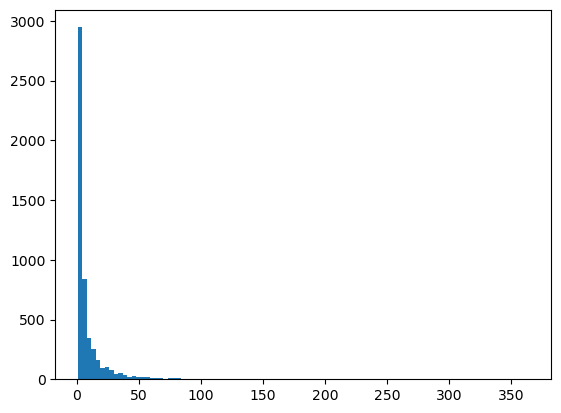

In [15]:
# What is the distribution of how many articles a user interacts with in the dataset?
plt.hist(article_count, bins=100);

In [16]:
# Most viewed article
user_count = df.groupby('article_id')['email'].count()

most_viewed_article_id = user_count.sort_values(ascending=False).index[0]
max_views = user_count.sort_values(ascending=False)[0]

print('Article #{} has the most views: {}'.format(most_viewed_article_id, max_views))

Article #1429 has the most views: 14


In [17]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


## Rank-Based Recommendations

We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

In [18]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('title')['user_id'].count().sort_values(ascending=False)[:n]
    
    return top_articles.index # Return the top article titles from df

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df.groupby('article_id')['user_id'].count().sort_values(ascending=False)[:n]

    return top_articles.index # Return the top article ids

In [19]:
print(get_top_articles(10))
print(get_top_article_ids(10))

Index(['use deep learning for image classification',
       'insights from new york car accident reports',
       'visualize car data with brunel',
       'use xgboost, scikit-learn & ibm watson machine learning apis',
       'predicting churn with the spss random tree algorithm',
       'healthcare python streaming application demo',
       'finding optimal locations of new store using decision optimization',
       'apache spark lab, part 1: basic concepts',
       'analyze energy consumption in buildings',
       'gosales transactions for logistic regression model'],
      dtype='object', name='title')
Index([1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304], dtype='int64', name='article_id')


## User-User Based Collaborative Filtering

### Helper functions

In [20]:
def create_user_item_matrix(df):
    ''' Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    
    INPUT
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT
    user_item - user item matrix 
    '''
    user_item = df.groupby(['user_id', 'article_id']).count().unstack()
    user_item.fillna(0, inplace=True)
    user_item[user_item > 1] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

In [21]:
def find_similar_users(user_id, user_item=user_item):
    '''Computes the similarity of every pair of users based on the dot product
    Returns an ordered list
    
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    '''
    
    # compute similarity of each user to the provided user
    sim_matrix = user_item.dot(user_item.loc[user_id].T)
    # sort by similarity
    sim_matrix = sim_matrix.sort_values(ascending=False)
    # create list of just the ids
    most_similar_users = list(sim_matrix.index)
    # remove the own user's id
    most_similar_users.remove(user_id)

    return most_similar_users # return a list of the users in order from most to least similar

In [22]:
# Spot check
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


In [23]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for id in article_ids:
        article_names.append(df[df['article_id'] == (id)]['title'].iloc[0])
    
    return article_names # Return the article names associated with list of article ids

### Simple Recommendation 

Use similar users to find articles to recommend >

In [24]:
def get_user_articles(user_id, user_item=user_item):
    ''' Provides a list of the article_ids and article titles that have been seen by a user
    
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    '''
    
    article_ids = user_item.loc[user_id]
    article_ids = [id for id in user_item.loc[user_id][user_item.loc[user_id] == 1]['title'].index]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names

In [25]:
def user_user_recs(user_id, m=10):
    ''' Get list of recommended articles
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    has_seen_ids = get_user_articles(user_id)[0]
    most_similar_users = find_similar_users(user_id)
    
    recs = []
    
    for user in most_similar_users:
        user_articles = get_user_articles(user)
        for id, title in zip(*user_articles):
            if id not in has_seen_ids:
                recs.append(id)
            if len(recs) == m:
                return recs # return your recommendations for this user_id  

In [26]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

### Refine Recommendation

- Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.

- Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions.

In [27]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
        '''
        INPUT:
        user_id - (int)
        df - (pandas dataframe) df as defined at the top of the notebook 
        user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise

                
        OUTPUT:
        neighbors_df - (pandas dataframe) a dataframe with:
                        neighbor_id - is a neighbor user_id
                        similarity - measure of the similarity of each user to the provided user_id
                        num_interactions - the number of articles viewed by the user - if a u

        '''

        similarity = user_item.dot(user_item.loc[user_id].T)
        interactions = df.groupby('user_id').count()
        interactions = interactions.drop('title', axis=1).rename(columns={'article_id':'num_interactions'})
        neighbors_df = interactions.join(pd.DataFrame(similarity).rename(columns={0:'similarity'}))
        neighbors_df = neighbors_df.sort_values(['similarity','num_interactions'],ascending=False)
        neighbors_df.drop(user_id, axis=0, inplace=True)

        return neighbors_df.index

In [28]:
def top_user_articles(user_id, user_item=user_item):
    ''' Provides a list of the article_ids that have been seen by a user
    sorted by num of interactions
    
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    '''
    
    interactions = df.groupby('article_id').count()
    interactions = interactions.drop('title', axis=1).rename(columns={'user_id':'num_interactions'})
    articles = interactions.loc[get_user_articles(user_id)[0]].sort_values('num_interactions', ascending=False)
    article_ids = articles.index
    
    return article_ids # return the ids and names

In [29]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 

    '''
    
    has_seen_ids = get_user_articles(user_id)[0]
    most_similar_users = get_top_sorted_users(user_id)
    
    recs = []
    
    for user in most_similar_users:
        user_articles = top_user_articles(user)
        for id in user_articles:
            if id not in has_seen_ids:
                recs.append(id)
            if len(recs) == m:
                rec_names = get_article_names(recs)
                return recs, rec_names
    


In [30]:
# Quick spot check
rec_ids, rec_names = user_user_recs(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:\n")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:\n")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:

[1330, 1427, 1364, 1170, 1162, 1304, 1351, 1160, 1354, 1368]

The top 10 recommendations for user 20 are the following article names:

['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'model bike sharing data with spss', 'analyze accident reports on amazon emr spark', 'movie recommender system with spark machine learning', 'putting a human face on machine learning']


## Matrix Factorization

### How many latent features?

In [31]:
# We already have our user_item matrix
user_item

title                                               ...            \
article_id  0    2    4    8    9    12   14   15   16   18    ... 1434 1435   
user_id                                                        ...             
1            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3            0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
5145         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5146         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5147         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5148         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
5149         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0   

                                                    
article_id 1436 1437 1439 1440 1441 1442 1443 1444  
user_id                                             
1           1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
2           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3           1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  
5145        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5146        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5147        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5148        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
5149        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5149 rows x 714 columns]

We can use build-in SVD function because the user_item_matrix has no NaN values. This is because we replaced NaN values with 0.

In [32]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item)

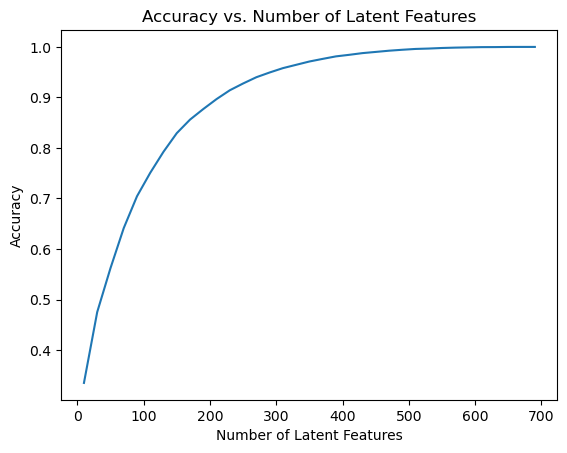

In [33]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Instead, we might split our dataset into a training and test set of data

In [34]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                    (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = user_item_test.index.values
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [35]:
# How many users can we make predictions for in the test set?
len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

20

In [36]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['user_id'].unique()) - len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

662

In [37]:
# How many articles can we make predictions for in the test set?
len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

574

In [38]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

0

explore how well SVD works towards making predictions for recommendations on the test data

In [39]:
# Users and articles in user_item_train matrix
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)

# Users and articles of test set in training set
test_idx_set = np.intersect1d(test_idx, train_idx)
test_arts_set = np.intersect1d(test_arts, train_arts)

# Users and articles positions of test subset in training matrix
train_indexes = np.where(np.in1d(train_idx, test_idx_set))[0]
train_articles = np.where(np.in1d(train_arts, test_arts_set))[0]

# Users positions of test subset in test matrix
test_indexes = np.where(np.in1d(test_idx, test_idx_set))[0]

In [40]:
# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [41]:
# Find subset where users are in both train and test
u_item_test_set = user_item_test.iloc[test_indexes,:]
u_item_train_set = user_item_train.iloc[train_indexes, train_articles]

In [42]:
latent_feats = np.arange(10,600,5)
sum_errors = []

for k in latent_feats:
    
    # Restructure train matrices using k features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # Restructure test matrices using k features
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_indexes,:], vt_train_k[:,train_articles]
    
    # Calculate dot product
    u_item_test_set_pred = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # Error (prediction - actual values)
    error = np.subtract(u_item_test_set, u_item_test_set_pred)
    
    # Total errors
    total_error = np.sum(np.sum(np.abs(error)))
    sum_errors.append(total_error)

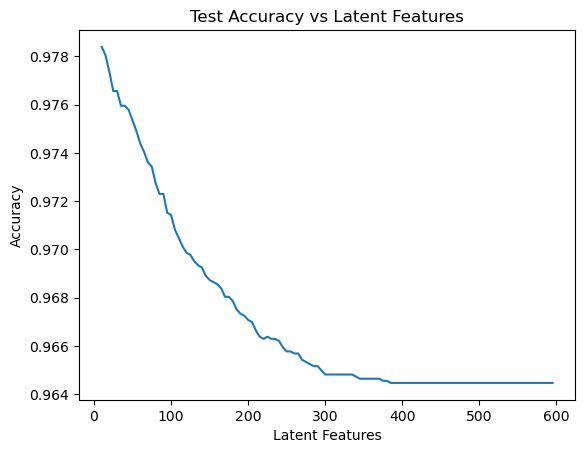

In [43]:
# Plot test accuracy and latent features
n_interactions_set = u_item_test_set.shape[0] * u_item_test_set.shape[1]
plt.plot(latent_feats, 1 - np.array(sum_errors) / n_interactions_set);
plt.xlabel('Latent Features');
plt.ylabel('Accuracy');
plt.title('Test Accuracy vs Latent Features');

There is a clear trend that accuracy approaches 100% as the # of latent features increases. On the flip side, the accuracy linked to the test dataset exhibits a downward trajectory as we use more latent features. A plausible reason for this divergence is the scant overlap in users between the training and test datasets (there's only 20), which could undermine the reliability of comparing predicted values to actual outcomes.

### Recommender accuracy

In [44]:
def create_user_item_matrix(df):
    ''' Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    
    INPUT
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT
    user_item - user item matrix 
    '''
    user_item = df.groupby(['user_id', 'article_id']).count().unstack()
    user_item.fillna(0, inplace=True)
    user_item[user_item > 1] = 1
    
    # Set the columns to the second level
    user_item.columns = user_item.columns.get_level_values(1)
    
    return user_item # return the user_item matrix 

In [45]:
def create_train_test(training_proportion, data=df):
    '''    
    INPUT:
    data - (pandas df) dataframe to split into train and test
    order_by - (string) column name to sort by
    training_proportion - (float) proportion of rows in training set
    
    OUTPUT:
    train_matrix -  (pandas df) dataframe of the training set
    validate_matrix - (pandas df) dataframe of the test set
    '''
    training_size = int(np.around(data.shape[0]*training_proportion))
    
    train_df = data.head(training_size)
    test_df = data.tail(data.shape[0] - training_size)
    
    train_matrix = create_user_item_matrix(train_df)
    test_matrix = create_user_item_matrix(test_df)
    
    return train_matrix, test_matrix


In [46]:
train_matrix, test_matrix = create_train_test(.8)

u_test, s_test, vt_test = np.linalg.svd(test_matrix)
u_train, s_train, vt_train = np.linalg.svd(train_matrix)

print(train_matrix)

def fit_SVD(U, S, Vt, k=-1):
    if k == -1:
        k = len(S)
    u_new = u[:, :k]

    s_new = np.zeros((k, k))
    s_new[:k, :k] = np.diag(s[:k])

    vt_new = vt[:k, :]
    
    return u_new, s_new, vt_new

u_train, s_train, vt_train = fit_SVD(u_train, s_train, vt_train)
u_test, s_test, vt_test = fit_SVD(u_test, s_test, vt_test)

article_id  0     2     4     8     9     12    14    15    16    18    ...  \
user_id                                                                 ...   
1            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3            0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  ...   
4            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
4121         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4122         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4123         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4124         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4125         0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [47]:
def predict_interaction(U, S, Vt, user_id, article_id, thresh=.5):
    '''
    INPUT:
    U - user by latent factor matrix
    Vt - latent factor by article matrix
    S - latent factors diagonal matrix
    user_id - the user_id from the users df
    article_id - the article_id according the article df
    
    OUTPUT:
    pred - the predicted rating for user_id-article_id according to SVD
    '''
    
    # Create series of users and movies in the right order
    user_ids = np.array(train_matrix.index)
    article_ids = np.array(train_matrix.columns)
    
    # User row and Movie Column
    user_row = np.where(user_ids == user_id)[0][0]
    article_col = np.where(article_ids == article_id)[0][0]
    
    user_vector = U[user_row, :]
    article_vector = Vt[:, article_col]
    
    # Take dot product of that row and column in U, S and VT to make prediction
    pred = np.dot(user_vector, np.dot(S, article_vector))
    
    # Convert the continuous prediction to a binary outcome based on the threshold
    return 1 if pred >= thresh else 0

In [48]:
def validation_comparison(test_matrix, U, S, Vt, thresh=.5):
    '''
    INPUT:
    val_df - the validation dataset created in the third cell above
    user_mat - U matrix in FunkSVD
    movie_mat - V matrix in FunkSVD
        
    OUTPUT:
    rmse - RMSE of how far off each value is from it's predicted value
    perc_rated - percent of predictions out of all possible that could be rated
    actual_v_pred - a 10 x 10 grid with counts for actual vs predicted values
    '''
    
    error = 0
    num_rated = 0
    preds, acts = [], []
    #actual_v_pred = np.zeros((10,10))
    for i in range(len(test_matrix)):
        for j in range(len(test_matrix.columns)):
            user_id = test_matrix.index[i]
            article_id = train_matrix.columns[j]
            try:
                pred = predict_interaction(U, S, Vt, test_matrix.index[i], train_matrix.columns[j], thresh)
                error += (test_matrix.loc[user_id, article_id] - pred) ** 2
                num_rated += 1
                preds.append(pred)
                acts.append(test_matrix.loc[user_id, article_id])
                #actual_v_pred[11-int(train_matrix.loc[i, j]-1), int(round(pred)-1)]+=1
            
            except:
                continue
    
    perc_rated = num_rated/test_matrix.size
    return num_rated, perc_rated, error, acts, pred

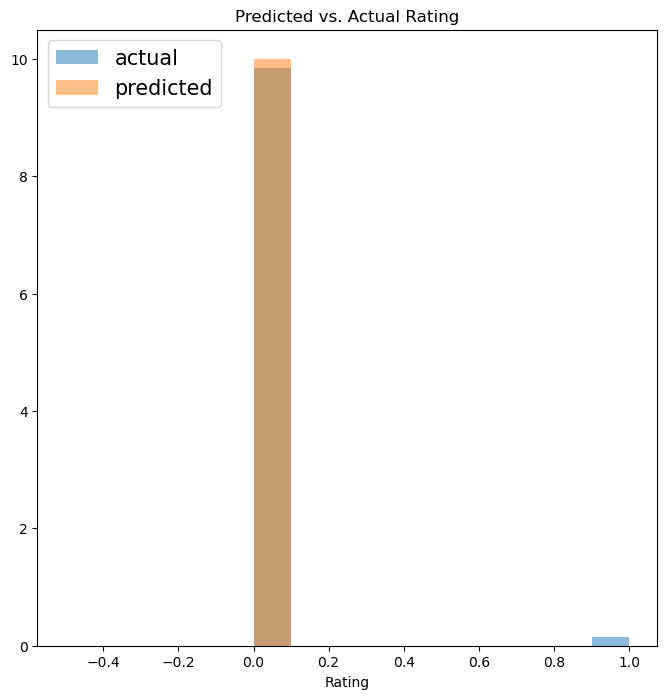

In [49]:
# How well did we do?

num_rated, perc_rated, error, acts, pred = validation_comparison(test_matrix, u_test, s_test, vt_test)

plt.figure(figsize=(8,8))
plt.hist(acts, density=True, alpha=.5, label='actual');
plt.hist(pred, density=True, alpha=.5, label='predicted');
plt.legend(loc=2, prop={'size': 15});
plt.xlabel('Rating');
plt.title('Predicted vs. Actual Rating');

In [50]:
# From the above, this can be calculated as follows:
not_rated = int(test_matrix.size*(1-perc_rated))
rated = int(test_matrix.size*perc_rated)

print("Percent rated {}".format(perc_rated))
print("Number not rated {}".format(not_rated))
print("Number rated {}.".format(rated))

Percent rated 0.016662354781880228
Number not rated 638548
Number rated 10820.


There is not enough overlap in users between the train and test sets to validate using SVD for predicting recommendations and know how well it will perform. That isn't to say we couldn't implement it though. We could, and then use on online methods to test efficacy. For instance, an A/B test, which could involve segmenting users into two groups of equal size through cookie assignments, where Group A interacts with rank-based recommendations, Group B engages with content-based recommendations, and Group C engages with the matrix-based recommendations.

## Build Recommender

### Rank Based For New Users

In [51]:
def get_top_articles(n, interactions_df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles_names - (list) A list of the top 'n' article titles 
    top_articles_ids - (list) A list of the top 'n' article ids
    
    '''
    top_articles_names = df.groupby('title')['user_id'].count().sort_values(ascending=False)[:n].index
    top_articles_ids = df.groupby('article_id')['user_id'].count().sort_values(ascending=False)[:n].index

    recommendations = pd.DataFrame({'article_id': top_articles_ids, 'title': top_articles_names})
    return recommendations  # Return the top articles from df

In [52]:
get_top_articles(8)

,article_id,title
0,1429,use deep learning for image classification
1,1330,insights from new york car accident reports
2,1431,visualize car data with brunel
3,1427,"use xgboost, scikit-learn & ibm watson machine..."
4,1364,predicting churn with the spss random tree alg...
5,1314,healthcare python streaming application demo
6,1293,finding optimal locations of new store using d...
7,1170,"apache spark lab, part 1: basic concepts"


### Content Based for new articles

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


def create_tfidf_matrix(descriptions: pd.Series) -> np.ndarray:
    """
    Convert article titles into a TF-IDF matrix.

    Args:
        descriptions (pd.Series): Series of article descriptions.

    Returns:
        np.ndarray: TF-IDF matrix representing the descriptions.
    """
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(descriptions)
    return tfidf_matrix

def find_similar_articles(article_index: int, tfidf_matrix: np.ndarray, titles: pd.Series, ids: pd.Series, top_n: int = 5) -> pd.DataFrame:
    """
    Find and return the top N most similar articles based on cosine similarity.

    Args:
        article_index (int): Index of the article to find similarities for.
        tfidf_matrix (np.ndarray): TF-IDF matrix of the article titles.
        titles (pd.Series): Series of article titles.
        top_n (int): Number of top similar articles to return.

    Returns:
        pd.DataFrame: DataFrame containing the top N similar articles with their titles and similarity scores.
    """
    cosine_similarities = cosine_similarity(tfidf_matrix[article_index:article_index+1], tfidf_matrix).flatten()
    
    # Sort the similarity scores in descending order and get the indices
    similar_indices = cosine_similarities.argsort()[::-1]
    
    # Exclude the query article itself (which is the first item in the sorted indices array)
    similar_indices = similar_indices[1:top_n+1]
    
    # Get the top N similar articles (excluding the query article)
    top_similarities = cosine_similarities[similar_indices]
    similar_articles = titles.iloc[similar_indices].reset_index(drop=True)
    article_ids = ids.iloc[similar_indices].reset_index(drop=True)
    similar_articles = pd.DataFrame({'article_id': article_ids, 'title': similar_articles, 'similarity': top_similarities})
    
    return similar_articles

In [87]:
tfidf_matrix = create_tfidf_matrix(df_content.doc_description)

# Get recommendations for the first article in your DataFrame
recommended_articles = find_similar_articles(8, tfidf_matrix, df_content['doc_full_name'], df_content['article_id'], 5)
print(recommended_articles)

  article_id                                              title  similarity
0        758      A glimpse inside the mind of a data scientist    0.275344
1        384                      Continuous Learning on Watson    0.237682
2        428  Data Science Experience Demo: Modeling energy ...    0.231130
3        569  How can data scientists collaborate to build b...    0.230265
4        444                       Declarative Machine Learning    0.191066


### Content Based for Exisiting Users

In [94]:
def create_article_profiles(content_df = df_content):
    """
    Create article profiles using TF-IDF based on titles and descriptions.
    """
    # Combine title and description into a single content column
    df_content['content'] = df_content['doc_full_name'] + ' ' + df_content['doc_description']
    
    # Initialize a TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    
    # Fit and transform the content to create TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_content['content'])
    
    return tfidf_matrix, tfidf_vectorizer

def recommend_articles(user_id, tfidf_matrix, content_df = df_content, interactions_df = df, top_n=5):
    """
    Recommend articles for a given user considering articles they've already read.
    """
    
    # Find articles read by the user
    read_articles = interactions_df[interactions_df['user_id'] == user_id]['article_id'].unique()
    
    # Get Indices for computing cosine similarity
    read_articles_indices = content_df[content_df['article_id'].isin(read_articles)]['article_id'].values
    
    # If the user has not read any "live" articles, return top N popular articles
    if len(read_articles_indices) == 0:
        return get_top_articles(top_n, interactions_df)
    
    # Compute similarity of read articles with all articles
    similarity = cosine_similarity(tfidf_matrix[read_articles_indices], tfidf_matrix)
    print(type(read_articles_indices))
    # Average the similarities
    avg_similarity = similarity.mean(axis=0)

    # Recommend top N articles not read by the user
    content_df['similarity'] = avg_similarity
    recommendations = content_df[~content_df['article_id'].isin(read_articles)].nlargest(top_n, 'similarity')
    
    return recommendations[['article_id', 'doc_full_name', 'similarity']]

In [95]:
# Create article profiles
tfidf_matrix, tfidf_vectorizer = create_article_profiles()

# Recommend articles for a user
user_id = 15  # Example user ID
recommendations = recommend_articles(user_id, tfidf_matrix)

print(recommendations)

<class 'numpy.ndarray'>
    article_id                              doc_full_name  similarity
318        318         Use dashDB with Pyspark and Pandas    0.191907
324        324                          MyCheatSheets.com    0.170148
110        110  PixieDust: Magic for Your Python Notebook    0.152907
189        189  Common Excel Tasks Demonstrated in Pandas    0.148575
325        325                        Map Your Cloud Data    0.143752


**Why Cosine Similarity**

Cosine similarity is often chosen over other distance measures in text processing and recommendation systems, particularly when dealing with high-dimensional data like TF-IDF vectors, for several reasons:

*Angle over Magnitude:* Cosine similarity measures the cosine of the angle between two vectors, effectively capturing their directional similarity regardless of their magnitude. This is particularly useful in text analysis where the frequency (magnitude) of words may vary significantly between documents, but the orientation (the relative frequency of terms) is more indicative of similarity.

*Sparse Data Handling:* Text data transformed into vectors, such as with TF-IDF, often results in sparse matrices where most elements are zero. Cosine similarity is adept at handling such sparsity because it focuses on non-zero dimensions, where the actual term matches occur, making it computationally efficient and relevant for text comparison.

*Normalization:* Cosine similarity inherently accounts for the length of the vectors, normalizing the dot product by the magnitudes of the vectors. This normalization is particularly useful in scenarios where the length of documents (or the number of terms) can vary widely, ensuring that the similarity measure is not biased by document length.

*Relevance in Textual Similarity:* In the context of text, similarity often implies that documents share terms. Cosine similarity directly measures this by assessing the overlap in terms through their vector representations, making it a natural fit for tasks like content-based filtering, where the goal is to find items (e.g., articles) with similar content.

*Widely Adopted in Information Retrieval:* Cosine similarity has a long-standing history of effective use in information retrieval and text mining applications. Its properties align well with the needs of these domains, such as ranking documents by relevance to a query, making it a trusted and go-to choice for developers and researchers.